# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for feature engineering
from feature_engine.creation import CyclicalFeatures

# for modelling
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

In [230]:
# load weekly sales dataset

filename = "../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


# Data analysis

First, explore the time series.

## Plot time series

In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2009-12-06 to 2011-12-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   106 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


In [232]:
min(df.index)

Timestamp('2009-12-06 00:00:00')

In [233]:
max(df.index)

Timestamp('2011-12-11 00:00:00')

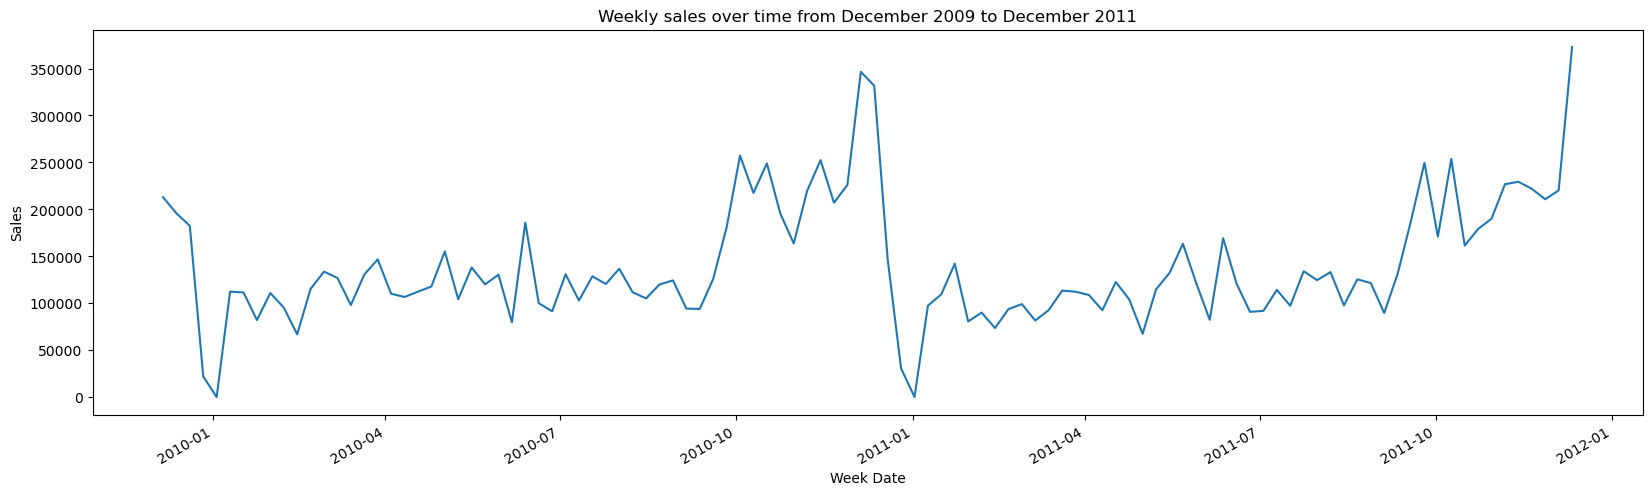

In [234]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
plt.plot(df.index, df['sales'])
plt.title('Weekly sales over time from December 2009 to December 2011')
plt.xticks(rotation = 30, ha = 'right')
plt.xlabel('Week Date')
plt.ylabel('Sales')
plt.show()

Based on the plot above, it is evident that there is a general pattern when looking at the bigger picture. 

Additionally, around December of each year, there is a huge spike in weekly sales. 

I believe that there is a clear seasonality trend here, and it is shown by this repetitive patterns and fluctatuions of weekly sales. More specifically, at the start of each year, there is a huge drop in sales relative to prior weeks in previous year, but shortly after the first week of each year, there sales start to go up again. Additionally, at the end of each year, there is a huge spike in weekly sales in around December of each year. Furthermore, sales tend to be have small fluctuations over time for each year from the second week of January up until around September. Subsequently, Sales seem to increase rapidly on the third week of September and dropped on the last week of September of each year. Moreover, weekly sales seem to jump rapidly at the first week of October of each year, dropped a little and increase again around mid October. After that, sales seem to spike steadily in November and rapidly in December. 

This means that we need to make sure that we let the model knows these kind of information later on to account for this. 

I also believe that in this data, there is a trend each year. More specifically, it can be seen that the weekly sales of each year start of very low and throughout the year, the weekly sales steadily rise over time, where it rapidly rises at the end of the year. 

Furthermore, I don't fully see if there is any irregular fluctations over longer time periods, and this could potentially be because we only have around 2 years of data, so not much extensive patterns can be identified. 

Moreover, it is also evident that there is no abnormal observations. For instance, no negative values can be found in the plot above. 

## Missing data

Check if there are missing values in the time series. 

In [235]:
sum(df['sales'].isnull()) # there are no missing values in this time series

0

## Missing timestamps

Check if there are missing timestamps in the index.

In [236]:
# # to check for missing timestamps, I need to first convert the time series to reflect this data that is being measured on weekly basis.
# df_ = df.asfreq('W')

# df_imputed = df_.fillna(method = 'ffill')

# # Plot the imputed time series.
# for var in ['sales', 'week']:

#     # plot the time series.
#     ax = df_[var].plot(linestyle="-", marker=".", figsize=[20, 4])

#     # plot the imputed values on top, in red.
#     df_imputed[df_.isnull()][var].plot(ax=ax, legend=None, marker=".", color="r")

#     # Add title.
#     plt.title(var)

#     # the y axis label
#     plt.ylabel(var)

#     plt.show()

But based on the graph plotted earlier, it is evident that there is no missing timestamps.

## Seasonality

Does the time series show any obvious seasonal pattern?

As mentioned earlier, there seems to be a clear seasonality trend in the graph.

# Feature engineering

Now, let's begin to tabularize the data.

## Temporal features

In [237]:
df['Month'] = df.index.month
df['Week'] = df.index.isocalendar().week
df['Day'] = df.index.day
df['Year'] = df.index.year
df['Quarter'] = df.index.quarter

## Periodic features

In seasonality, there is the end and the beginning of a cycle and the model won't be able to capture this transition between the end and the beginning of a cycle if we do not feature engineer it. Most importantly, with numerical representations of months, the model would assume that December and January are at the opposite end of the scale, making them appear far apart. However, in reality, these months are adjacent and share similar seasonal characteristics. Thus, we need to find a way to capture this reality. Ultimately, by doing this, the model would be able to recognize that December and January are close in terms of seasonality, even though their numerical representations might suggest otherwise. 

In [238]:
cyclical = CyclicalFeatures(
    variables = ['Month', 'Week'],
    drop_original = False
)
df = cyclical.fit_transform(df)

## Lagged features

Notably, I will include the following lagged features:

- previous week sales
- previous two weeks sales
- previous month sales

In [239]:
# 1 week lag
temp = pd.DataFrame(df['sales'].shift(periods = 1))

temp.rename(
    columns = {
        'sales': 'sales_previous_week'
    },
    inplace = True
)

df = df.merge(temp, left_index = True, right_index = True, how = 'left')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2009-12-06 to 2011-12-11
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sales                106 non-null    float64
 1   Month                106 non-null    int32  
 2   Week                 106 non-null    UInt32 
 3   Day                  106 non-null    int32  
 4   Year                 106 non-null    int32  
 5   Quarter              106 non-null    int32  
 6   Month_sin            106 non-null    float64
 7   Month_cos            106 non-null    float64
 8   Week_sin             106 non-null    Float64
 9   Week_cos             106 non-null    Float64
 10  sales_previous_week  105 non-null    float64
dtypes: Float64(2), UInt32(1), float64(4), int32(4)
memory usage: 8.2 KB


In [240]:
temp = pd.DataFrame(df['sales'].shift(periods = 2))

temp.rename(
    columns = {
        'sales': 'sales_previous_two_weeks'
    },
    inplace = True
)

df = df.merge(temp, left_index = True, right_index = True, how = 'left')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2009-12-06 to 2011-12-11
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sales                     106 non-null    float64
 1   Month                     106 non-null    int32  
 2   Week                      106 non-null    UInt32 
 3   Day                       106 non-null    int32  
 4   Year                      106 non-null    int32  
 5   Quarter                   106 non-null    int32  
 6   Month_sin                 106 non-null    float64
 7   Month_cos                 106 non-null    float64
 8   Week_sin                  106 non-null    Float64
 9   Week_cos                  106 non-null    Float64
 10  sales_previous_week       105 non-null    float64
 11  sales_previous_two_weeks  104 non-null    float64
dtypes: Float64(2), UInt32(1), float64(5), int32(4)
memory usage: 9.0 KB


In [241]:
temp = pd.DataFrame(df['sales'].shift(periods = 4))

temp.rename(
    columns = {
        'sales': 'sales_previous_month'
    },
    inplace = True
)

df = df.merge(temp, left_index = True, right_index = True, how = 'left')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2009-12-06 to 2011-12-11
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sales                     106 non-null    float64
 1   Month                     106 non-null    int32  
 2   Week                      106 non-null    UInt32 
 3   Day                       106 non-null    int32  
 4   Year                      106 non-null    int32  
 5   Quarter                   106 non-null    int32  
 6   Month_sin                 106 non-null    float64
 7   Month_cos                 106 non-null    float64
 8   Week_sin                  106 non-null    Float64
 9   Week_cos                  106 non-null    Float64
 10  sales_previous_week       105 non-null    float64
 11  sales_previous_two_weeks  104 non-null    float64
 12  sales_previous_month      102 non-null    float64
dtypes: Float64(2), UInt32(1), float64(6), int32(4)

## Window features

We can create features to inform the machine the average sales of the last month, or the last two weeks.

In [242]:
# use the mean of the previous 2 weeks as input variables
temp = pd.DataFrame(df['sales'].rolling(window = 2).mean().shift(periods = 1))

temp.rename(
    columns = {
        'sales': 'previous_2_weeks_avg_sales'
    },
    inplace = True
)

df = df.merge(temp, left_index = True, right_index = True, how = 'left')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2009-12-06 to 2011-12-11
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sales                       106 non-null    float64
 1   Month                       106 non-null    int32  
 2   Week                        106 non-null    UInt32 
 3   Day                         106 non-null    int32  
 4   Year                        106 non-null    int32  
 5   Quarter                     106 non-null    int32  
 6   Month_sin                   106 non-null    float64
 7   Month_cos                   106 non-null    float64
 8   Week_sin                    106 non-null    Float64
 9   Week_cos                    106 non-null    Float64
 10  sales_previous_week         105 non-null    float64
 11  sales_previous_two_weeks    104 non-null    float64
 12  sales_previous_month        102 non-null    float64
 13  previous_2_weeks

In [243]:
temp = pd.DataFrame(df['sales'].rolling(window = 4).mean().shift(periods = 1))

temp.rename(
    columns = {
        'sales': 'previous_month_avg_sales'
    },
    inplace = True
)

df = df.merge(temp, left_index = True, right_index = True, how = 'left')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2009-12-06 to 2011-12-11
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sales                       106 non-null    float64
 1   Month                       106 non-null    int32  
 2   Week                        106 non-null    UInt32 
 3   Day                         106 non-null    int32  
 4   Year                        106 non-null    int32  
 5   Quarter                     106 non-null    int32  
 6   Month_sin                   106 non-null    float64
 7   Month_cos                   106 non-null    float64
 8   Week_sin                    106 non-null    Float64
 9   Week_cos                    106 non-null    Float64
 10  sales_previous_week         105 non-null    float64
 11  sales_previous_two_weeks    104 non-null    float64
 12  sales_previous_month        102 non-null    float64
 13  previous_2_weeks

Ultimately, I have feature engineered all the relevant features. However, after doing this, there are missing values generated. Therefore, I am going to drop observations with missing values because not a lot of data points are missing.

In [244]:
df.isnull().sum()/len(df)

sales                         0.000000
Month                         0.000000
Week                          0.000000
Day                           0.000000
Year                          0.000000
Quarter                       0.000000
Month_sin                     0.000000
Month_cos                     0.000000
Week_sin                      0.000000
Week_cos                      0.000000
sales_previous_week           0.009434
sales_previous_two_weeks      0.018868
sales_previous_month          0.037736
previous_2_weeks_avg_sales    0.018868
previous_month_avg_sales      0.037736
dtype: float64

In [245]:
df.dropna(inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102 entries, 2010-01-03 to 2011-12-11
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sales                       102 non-null    float64
 1   Month                       102 non-null    int32  
 2   Week                        102 non-null    UInt32 
 3   Day                         102 non-null    int32  
 4   Year                        102 non-null    int32  
 5   Quarter                     102 non-null    int32  
 6   Month_sin                   102 non-null    float64
 7   Month_cos                   102 non-null    float64
 8   Week_sin                    102 non-null    Float64
 9   Week_cos                    102 non-null    Float64
 10  sales_previous_week         102 non-null    float64
 11  sales_previous_two_weeks    102 non-null    float64
 12  sales_previous_month        102 non-null    float64
 13  previous_2_weeks

## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [246]:
train_set = df.loc[df.index <= '2011-09-25', :]
test_set = df.loc[df.index > '2011-09-25', :]

In [247]:
min(train_set.index)

Timestamp('2010-01-03 00:00:00')

In [248]:
max(train_set.index)

Timestamp('2011-09-25 00:00:00')

In [249]:
min(test_set.index)

Timestamp('2011-10-02 00:00:00')

In [250]:
max(test_set.index)

Timestamp('2011-12-11 00:00:00')

In [251]:
X_train = pd.DataFrame(train_set.drop(columns = ['sales']))
y_train = pd.DataFrame(train_set['sales'])

X_test = pd.DataFrame(test_set.drop(columns = ['sales']))
y_test = pd.DataFrame(test_set['sales'])

## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [252]:
print(
    'train rmse: ', 
    mean_squared_error(
        y_train, X_train['sales_previous_week'], squared = False
    )
)

print(
    'test rmse: ',
    mean_squared_error(
        y_test, X_test['sales_previous_week'], squared = False
    )
)

train rmse:  45844.30745262792
test rmse:  65327.34284108387


/Users/hiimpian/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/hiimpian/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Machine Learning

## Lasso-penalized regression

In [253]:
linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train, y_train)

Lasso(alpha=100, random_state=0)

In [254]:
# Performance of linear model

print("train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))

train rmse:  34602.267882919215
test rmse:  55646.56553829003


/Users/hiimpian/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/hiimpian/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Feature importance

Text(0, 0.5, 'Degree of Importance')

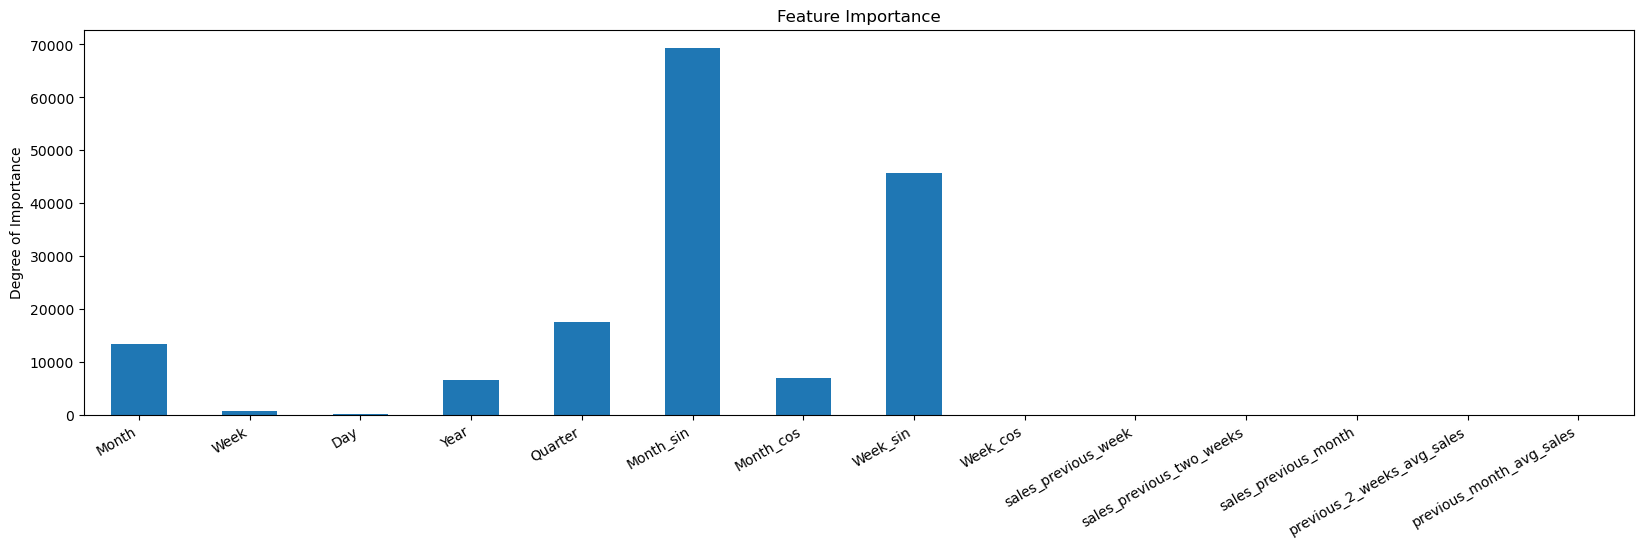

In [255]:
temp =  pd.Series(np.abs(linear_model.coef_))

temp.index = X_train.columns

temp.plot.bar(figsize = (20, 5))
plt.xticks(rotation = 30, ha = 'right')
plt.title('Feature Importance')
plt.ylabel('Degree of Importance')

## Random Forest

In [256]:
rf_model = RandomForestRegressor(
    n_estimators=5,
    max_depth=1,
    random_state=0,
)

rf_model.fit(X_train, y_train)

/Users/hiimpian/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=1, n_estimators=5, random_state=0)

In [257]:
print("train rmse: ", mean_squared_error(
    y_train, rf_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, rf_model.predict(X_test), squared=False,))

train rmse:  39018.373236073494
test rmse:  56972.16229966185


/Users/hiimpian/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/hiimpian/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0, 0.5, 'Degree of Importance')

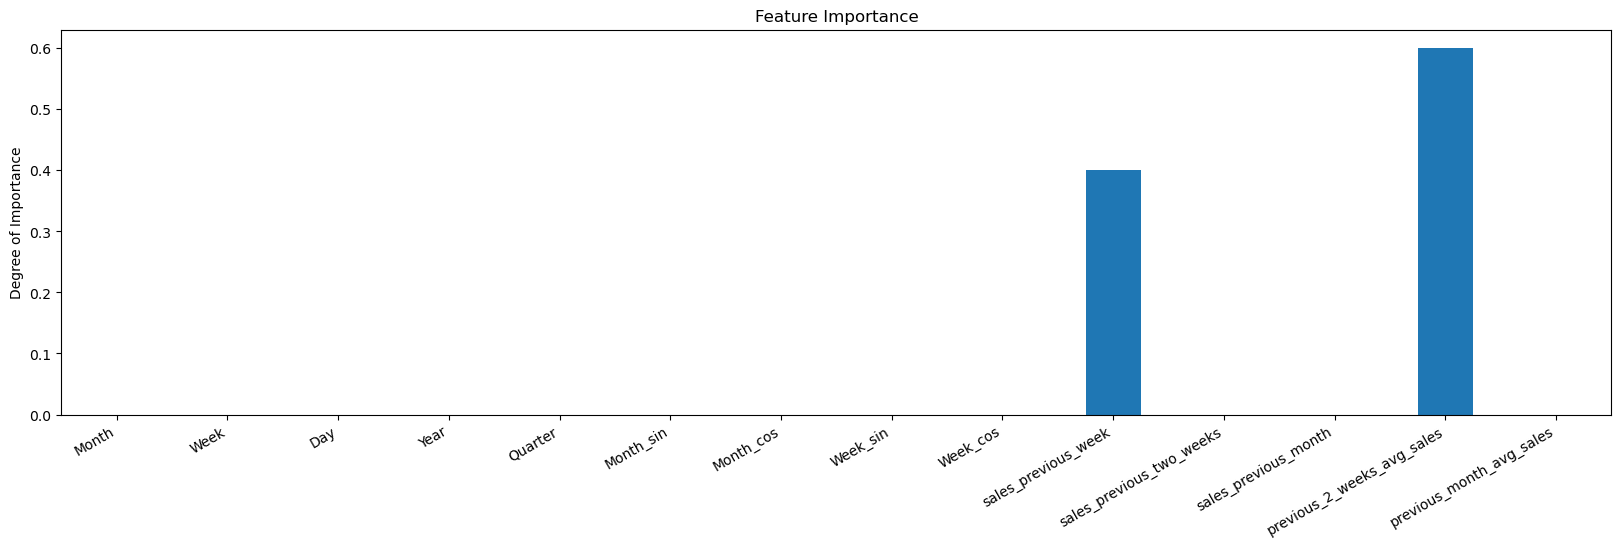

In [259]:
temp =  pd.Series(np.abs(rf_model.feature_importances_))

temp.index = X_train.columns

temp.plot.bar(figsize = (20, 5))
plt.xticks(rotation = 30, ha = 'right')
plt.title('Feature Importance')
plt.ylabel('Degree of Importance')